### Really basic approach to Gaussian Process Forecasting on our Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared,
    ConstantKernel,
    Matern,
)

#### First apply data preparation & cleaning - which I don't do here...

In [3]:
df_test = pd.read_csv("../data/DailyDelhiClimateTest.csv")
df_train = pd.read_csv("../data/DailyDelhiClimateTrain.csv")

In [4]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


#### Convert date-variable to datetime format

In [7]:
df_train["date"] = pd.to_datetime(df_train["date"])
print(df_train.dtypes)

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object


In [8]:
df_test["date"] = pd.to_datetime(df_test["date"])
print(df_test.dtypes)

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object


#### Extract variable month from date and use it as feature, to incorporate seasonality
##### Maybe even define a more fine granular variable for this?? And/Or an variable for the seasons itself (spring, summer, autumn, ..) idk??

In [14]:
mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

In [20]:
df_train["month"] = df_train["date"].dt.month
df_test["month"] = df_test["date"].dt.month
# df_train['month'] = df_train['month'].map(mapping)
# df_test["month"]  = df_test["month"].map(mapping)

#### Split datasets in response and feature variables

In [21]:
y_train = df_train["meantemp"]
X_train = df_train[["humidity", "wind_speed", "meanpressure", "month"]]
y_test = df_test["meantemp"]
X_test = df_test[["humidity", "wind_speed", "meanpressure", "month"]]

In [ ]:
### Now define the input kernels (which define the function space of the gaussian process we are sampling out of)
#### Explanation: If we define a linear kernel, we will only get linear functions, since we are sampling from a function space containing solely linear functions
####  It is possible to combine different Kernels
####  My idea is:
####     - White Noise kernel: Encodes the variance of the training data (sigma square)
####     - A linear or maybe non-linear trend (gotta do some research):
####           To show general temperature development on earth/ or especially in India. It will definetely be positive due to climate change.. (Let's check what yearly temperature rise we'd expect)
####     - Some periodic or seasonal kernel, that shows the temperature differences througout the year
####          - Here combine 2 periodic kernels:
####              - One general one for the seasons in a year (temperature rising in spring, hitting max in summer, then loweruing)
####              - One for the variations within the seasons

In [24]:
### For all the kernels I just took some random values. Since I have not really an idea what they do (yet)
### As I undersstood these are hyperparameters, but the will be optimized during the fitting of "GaussianProcessRegressor".
### I think you can even leave most of them empty and let it start with default values, but the starting point will definitely have an impact on the model performance

In [64]:
## White-Noise-Kernel, combine with RBF kernel to capture smooth and continous variatens over time
# noise_level = y_train.std() # no idea if this makes sense...
# print(noise_level)
k1 = RBF() + WhiteKernel(noise_level=0.1)  # , noise_level_bounds=(0.1**2, 0.5**2) )

In [65]:
## Linear Trend (temperature rise trend per day)
k2 = ConstantKernel(constant_value=0.1)

In [78]:
# Periodic kernel for seasonal variability
# Periodicity (repeats it self after every 90 days? Quartals? Not sure if that might even be 365 days)
# length_scale: no idea yet
# periodicity bounds: The range in which the temperature usually varies (get that from the data)
# k3 = ExpSineSquared(length_scale= 1.0,periodicity=90)#, periodicity_bounds=(12,49))
k3 = RBF() + ExpSineSquared(length_scale=1.0)

In [90]:
# RBF Kernel + Matérn Kernel:

# RBF kernel captures smooth variations and trends in the temperature data.
# Matérn kernel is a flexible kernel that can model both short-term and long-term dependencies in the temperature data.
k4 = RBF() + Matern()

In [91]:
k5 = ConstantKernel() * RBF() + ExpSineSquared()

In [101]:
kernel = k1 + k3

In [102]:
# Here also random hyperparameters (but saw n_restarts_optimizer=10 in several sources)
model = gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)

In [103]:
model.fit(X_train, y_train)
params = model.kernel_.get_params()

c:\Users\basti\OneDrive\Documents\Prob ML Projekt\project_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [104]:
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)

In [105]:
gp_mean = model.predict(X_test)
print(gp_mean)

[25.4955209  13.46294303 12.6878717  15.08028058 15.82898047 17.16656911
 14.16351918 13.2500989  14.13654769 14.90412608 15.02716296 15.01743734
 13.85120323 13.45410191 13.86848439 14.6511749  12.99024829 12.19431506
 12.18678452 11.60806751 12.78745613 12.41772807 13.02425676 13.62131406
 13.66025992 13.0427839  14.21951059 13.28395675 14.01939101 14.6842307
 15.16480043 15.39593423 16.2723396  15.28814087 18.1354482  18.12239842
 17.56066612 17.40054834 17.74992504 17.18176728 17.91950929 17.67187296
 15.68905333 14.00054712 14.19319796 14.59541855 17.70247551 17.01977066
 17.34772943 19.09719579 23.10753414 22.24493258 20.92062667 19.80136379
 19.26003975 20.48752774 20.29973731 20.19897001 23.61345364 24.88073434
 24.54224873 25.9811567  25.96979269 25.46745205 25.50905284 28.10901443
 25.49443619 24.37504831 24.59510999 23.8778312  22.34465823 22.78158388
 22.55781885 23.23463137 25.9535154  23.58640823 26.19133691 24.23781733
 23.44769237 24.50620911 25.56061337 27.49883795 25.

In [106]:
test_indices = X_test.index
X_test.shape

(114, 4)

In [107]:
df_compare = pd.DataFrame(
    {"date": df_test.loc[test_indices, "date"], "True Y": y_test, "Predicted Y": y_pred}
)
df_compare.head()

,date,True Y,Predicted Y
0,2017-01-01,15.913043,25.495521
1,2017-01-02,18.500000,13.462943
2,2017-01-03,17.111111,12.687872
3,2017-01-04,18.700000,15.080281
4,2017-01-05,18.388889,15.828980


In [108]:
MSE = ((y_pred - y_test) ** 2).mean()
MSE

8.788988365840128

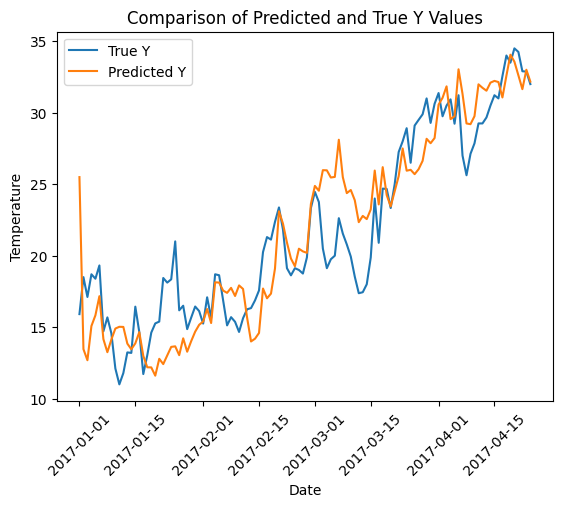

In [109]:
import matplotlib.pyplot as plt

# Assuming df_compare is the dataframe containing the date column, true y values, and predicted y values
plt.plot(df_compare["date"], df_compare["True Y"], label="True Y")
plt.plot(df_compare["date"], df_compare["Predicted Y"], label="Predicted Y")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Comparison of Predicted and True Y Values")
plt.legend()
plt.xticks(rotation=45)
plt.show()

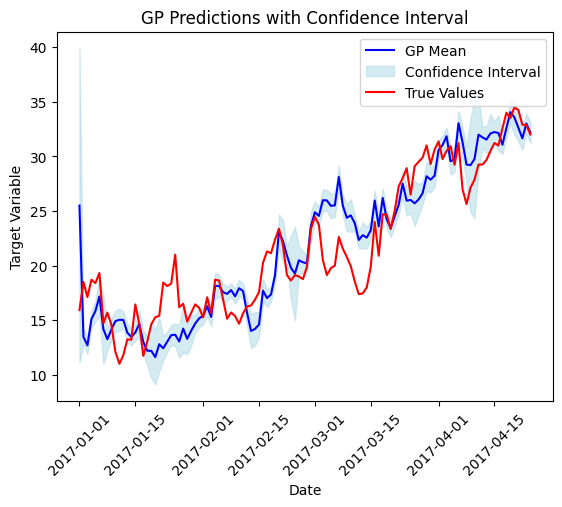

In [110]:
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, gp_std, and date_variable are available
dates = df_test[
    "date"
]  # Replace 'date_variable' with the actual date variable from your dataset

# Plotting the GP mean line
plt.plot(dates, y_pred, color="blue", label="GP Mean")

# Plotting the confidence interval as a shaded region
lower_bound = y_pred - 1.96 * std
upper_bound = y_pred + 1.96 * std
plt.fill_between(
    dates,
    lower_bound,
    upper_bound,
    color="lightblue",
    alpha=0.5,
    label="Confidence Interval",
)

# Plotting the true values
plt.plot(dates, y_test, color="red", label="True Values")

# Setting labels and title
plt.xlabel("Date")
plt.ylabel("Target Variable")
plt.title("GP Predictions with Confidence Interval")
plt.legend()

# Rotating x-axis tick labels if needed
plt.xticks(rotation=45)

# Displaying the plot
plt.show()